In [1]:
# take some big samples of papers and generate reduced dimensional spaces suitable for use with
#   the entire dataset

import mysql.connector as mysql

import time
import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import json
plt.rcParams['svg.fonttype'] = 'none'

In [2]:


db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
client_config = {'unix_socket':'/home/brendanchambers/.sql.sock',
                'database': db_name,
                'use_pure': True}  # for python connector

db = mysql.connect(**client_config)

## grab a sample of pmids from file 

In [3]:
sampleset_id = 0
path2dir = '/project2/jevans/brendan/pubmed_data_processing/sample_pmids/'
filename = 'sample{}.json'.format(sampleset_id)
path2pmids = path2dir + filename
with open(path2pmids,'r') as f:
    data = json.load(f)

print('overview:')
print('sample fraction: {}'.format(data['sample_fraction']))
print('resample? {} '.format(data['do_resample']))
sample_pmids = [row[0] for row in data['sample_rows']]  # ignore year and journal info here
print("n samples: {}".format(len(sample_pmids)))


#sample_pmids = sample_pmids[:10000]
str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])
del sample_pmids
del data  # wondering if we're short on RAM on the broadwl partition...so try deleting

print(str_fmt[:1000])

overview:
sample fraction: 0.0033333
resample? False 
n samples: 98470
25970969, 18005910, 944382, 15443245, 14172513, 20581438, 7265613, 11043898, 1470424, 19033446, 19965538, 1432871, 6795314, 2991764, 15844742, 17455947, 5049147, 6276105, 23645090, 18840511, 22433935, 7980431, 16654737, 28506381, 16942084, 24885873, 8053439, 21696614, 11721178, 9051560, 19332208, 24507326, 11978660, 30608698, 17632460, 5489778, 3774734, 3362706, 15599500, 25109710, 25057884, 26316076, 1332890, 1595720, 29589334, 19249655, 30749983, 14298960, 25957335, 27737104, 23583020, 29425040, 1186362, 20185778, 930247, 16787112, 29719396, 14180133, 3046483, 24766168, 17379427, 2292202, 8519173, 16336911, 24509284, 19820396, 17575863, 12098520, 28238793, 25903339, 24106947, 24685065, 28381729, 15493442, 26414051, 13805695, 24484909, 11880454, 19438644, 16125780, 13940566, 977543, 19284012, 8506673, 23051066, 28775526, 28191975, 8849822, 18164217, 14342219, 28407634, 12533011, 5079491, 17938627, 30368345, 4898387

## join associated embeddings on pmid

In [4]:
sql = '''SELECT E.pmid, E.embedding
            FROM scibert_mean_embedding as E
            WHERE E.pmid IN ({})'''.format(str_fmt)
start_time = time.time()
cursor = db.cursor()
cursor.execute(sql)
output = cursor.fetchall()
cursor.close()

end_time = time.time()
elapsed = end_time - start_time
print("sql join executed in {} s".format(elapsed))
print()

sql join executed in 3064.9576065540314 s



## translate blobs to np float64 array

In [5]:
sample_embeddings = np.array([np.frombuffer(row[1],dtype='float64') for row in output])
print(np.shape(sample_embeddings))

(94188, 768)


sample 1...


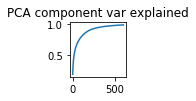

elapsed: 22.439595222473145


In [8]:
# run pca  (todo update with new workflow)

print('sample 1...')

start_time = time.time()

D = 728
D_pca = 728
#L = len(sample1)
#sample_embeddings = np.zeros(L, D)
#for i,sample in enumerate(sample1):
#    sample_embeddlings[i,:] = sample
    
pca = PCA(n_components=D_pca)
pc = pca.fit_transform(sample_embeddings)


# var explained
plt.figure(figsize=(1,1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA component var explained')  
plt.show()

end_time = time.time()
print("elapsed: {}".format(end_time - start_time))



In [14]:
# save the pca model
    
import pickle

# Save to file in the current working directory
pkl_filename = "pca_model1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)



Text(0.5, 1.0, 'first 2 PCs')

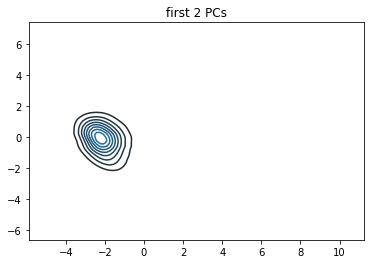

In [10]:
import seaborn as sns

plt.figure()
sns.kdeplot(pc[:,0],pc[:,1])
plt.title('first 2 PCs')


/home/brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Text(0.5, 1.0, 'umap 2D')

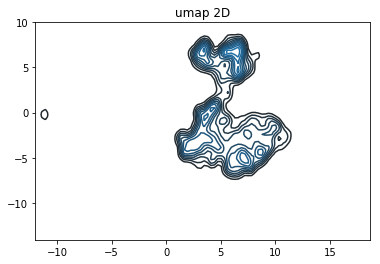

In [11]:
import umap

D_umap = 2
reducer = umap.UMAP(n_components=D_umap)
um = reducer.fit_transform(sample_embeddings)    # concatenated

plt.figure()
sns.kdeplot(um[:,0],um[:,1])
plt.title('umap 2D')

In [ ]:
# todo export and viz

In [6]:
db.close()

PCA(copy=True, iterated_power='auto', n_components=600, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


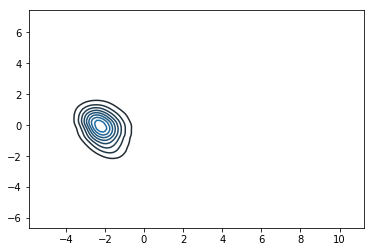

In [19]:
# test: Load from file

with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
print(pickle_model)
test = pickle_model.fit_transform(sample_embeddings)

plt.figure()
sns.kdeplot(test[:,0], test[:,1])
plt.show()